Ramsey Fringes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from quantumsystem import ThreeLevelLambdaSystem

In [106]:
intensity = 1 #[W/m^2]
constants = ThreeLevelLambdaSystem(intensity1=intensity,intensity2=intensity,units='SI')
# set initial values
p11, p22, p33 = 0.5, 0.5, 0
p12, p13, p23 = 0, 0, 0
w1 = np.sqrt(constants.rabi1_squared)/1e6 #[MHz] Rabi frequency 1
w2 = np.sqrt(constants.rabi2_squared)/1e6 #[MHz] Rabi frequency 2
# w1=w2=1
d1, d2 = 0, 0 #[MHz] one-photon detunings
# g3=1
g3 = 370 #[MHz] Excited state total relaxation rate 
g31 = g3/2 #[MHz] Relaxation rate from 3->1 
g32 = g3/2 #[MHz] Relaxation rate from 3->2

gf = g3/2 #[MHz] excited <-> ground state decoherence rate 
gs = 0 #[MHz] ground state decoherence rate

t1 = 50 #[s] First pulse length
tfree = 50 #[mus] Ramsey/dark time
tmeasure = .1  #[mus] measurement pulse length
tmax = t1+tfree+tmeasure #[mus] total sequence length

# initialize other variables

P0 = np.array([p11, p22,p33, p12, p13, p23], dtype='complex')

Using SI units


In [86]:
# eoms
"""
P[0] = p11
P[1] = p22
P[2] = p33
P[3] = p12
P[4] = p13
P[5] = p23
"""
def dP_dt(t, P, w1, w2, d1, d2):
    Pt = np.zeros(6, dtype='complex')
    p11,p22,p33,p12,p13,p23 = P
    p21 = np.conj(p12)
    p31 = np.conj(p13)
    p32 = np.conj(p23)
    
    Pt[0] = 1j*(w1/2)*(-p13+p31) + g31*p33 + gs*(p22-p11)
    Pt[1] = 1j*(w2/2)*(-p23+p32) + g32*p33 - gs*(p22-p11)
    Pt[2] = 1j*((w1/2)*(p13-p31) + (w2/2)*(p23-p32)) - g3*p33
    Pt[3] = 1j*((d1+d2)*p12 + (w1/2)*p32 - (w2/2)*p13) - gs*p12
    Pt[4] = 1j*(d1*p13 + (w1/2)*(p33-p11) - (w2/2)*p12) - gf*p13
    Pt[5] = 1j*(-d2*p23 + (w2/2)*(p33-p22) - (w1/2)*p21) - gf*p23
    return Pt

In [87]:
def juneRamsey(t,P,w1,w2,d1,d2):
    if t <= t1:
        return dP_dt(t,P,w1,w2,d1,d2)
    elif t1 < t <= t1+tfree:
        return dP_dt(t,P,0,0,d1,d2)
    elif t1+tfree < t <= t1+tfree+tmeasure:
        return dP_dt(t,P,w1,w2,d1,d2)
    

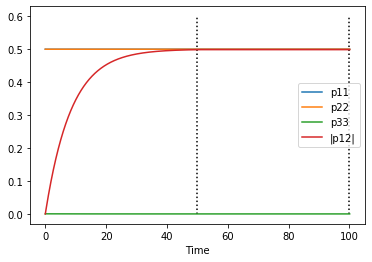

In [107]:

result = solve_ivp(lambda t,y: juneRamsey(t,y,w1,w2,d1=0,d2=0), [0,tmax], P0)
#NOTE: the time spacing in result.y is not linear!
#solve_ivp must change the t-step mid-solve or something
#use result.t to get the time array
t = result.t
p11,p22,p33,p12,p13,p23=result.y
plt.plot(t,p11.real,label='p11')
plt.plot(t,p22.real,label='p22')

plt.plot(t,p33.real,label='p33')
plt.plot(t,abs(p12.real),label='|p12|')
# plt.plot(t,abs(p13.real),label='|p13|')
# plt.plot(t,abs(p23.real),label='|p23|')

plt.xlabel('Time')
plt.vlines([t1,t1+tfree],0,0.6,linestyles='dotted')
plt.legend()

Text(0.5, 1.0, 'Ramsey Fringes')

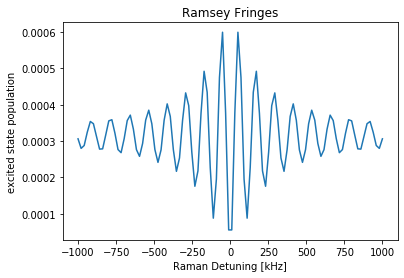

In [113]:
# Generate Ramsey Fringes
d=1000/1e3 #[MHz]
steps=100
detuning = np.linspace(-d,d,steps)
tspan = (0,tmax)
excited_state = []
for d in detuning:
    result = solve_ivp(lambda t,y: juneRamsey(t,y,w1,w2,d/2,d/2), tspan, P0,t_eval=[tmax])
    #Note: the t_eval parameter just indicates at what time values the solution is stored
    # we only are interested in the p33 population at the end of the Ramsey sequence so I set t_eval=[tmax]
    p11,p22,p33,p12,p13,p23=result.y
    excited_state.append(p33[0].real)
    
plt.plot(detuning*1e3,excited_state)
plt.xlabel("Raman Detuning [kHz]")
plt.ylabel("excited state population")
plt.title('Ramsey Fringes')